https://notebook.community/turbomanage/training-data-analyst/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/4_keras_functional_api

In [1]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow import feature_column as fc

from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Dense, DenseFeatures, concatenate)
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [2]:
%matplotlib inline

In [118]:
CSV_COLUMNS = ['fare_amount',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ['key']

def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
    
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)
    
    return features, label

def create_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
#    dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS, LABEL_COLUMN)
    dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
    
    # feature, label이 쌍으로 분리 + key 제거
    dataset = dataset.map(features_and_labels)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()
        
    dataset = dataset.prefetch(1)
    return dataset

In [119]:
# 1. Bucketize latitudes and longitudes
NBUCKETS = 16
latbuckets = np.linspace(start=38.0, stop=42.0, num=NBUCKETS).tolist()
lonbuckets = np.linspace(start=-76.0, stop=-72.0, num=NBUCKETS).tolist()

fc_bucketized_plat = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_longitude"), boundaries=lonbuckets)
fc_bucketized_plon = fc.bucketized_column(
    source_column=fc.numeric_column("pickup_latitude"), boundaries=latbuckets)
fc_bucketized_dlat = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_longitude"), boundaries=lonbuckets)
fc_bucketized_dlon = fc.bucketized_column(
    source_column=fc.numeric_column("dropoff_latitude"), boundaries=latbuckets)

# 2. Cross features for locations
fc_crossed_dloc = fc.crossed_column(
    [fc_bucketized_dlat, fc_bucketized_dlon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_ploc = fc.crossed_column(
    [fc_bucketized_plat, fc_bucketized_plon],
    hash_bucket_size=NBUCKETS * NBUCKETS)
fc_crossed_pd_pair = fc.crossed_column(
    [fc_crossed_dloc, fc_crossed_ploc],
    hash_bucket_size=NBUCKETS**4)

# 3. Create embedding columns for the crossed columns
fc_pd_pair = fc.embedding_column(categorical_column=fc_crossed_pd_pair, dimension=3)
fc_dloc = fc.embedding_column(categorical_column=fc_crossed_dloc, dimension=3)
fc_ploc = fc.embedding_column(categorical_column=fc_crossed_dloc, dimension=3)

In [120]:
wide_columns = [
    # One-hot encoded feature crosses
    fc.indicator_column(fc_crossed_dloc),
    fc.indicator_column(fc_crossed_ploc),
    fc.indicator_column(fc_crossed_pd_pair)
]

deep_columns = [
    # Embedding_column to "group" together ...
    fc.embedding_column(fc_crossed_pd_pair, dimension=10),

    # Numeric columns
    fc.numeric_column("pickup_latitude"),
    fc.numeric_column("pickup_longitude"),
    fc.numeric_column("dropoff_longitude"),
    fc.numeric_column("dropoff_latitude")
]

In [121]:
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count'
]

inputs = {colname : Input(name=colname, shape=(), dtype='float32')
          for colname in INPUT_COLS
}
list(inputs.values())

[<KerasTensor: shape=(None,) dtype=float32 (created by layer 'pickup_longitude')>,
 <KerasTensor: shape=(None,) dtype=float32 (created by layer 'pickup_latitude')>,
 <KerasTensor: shape=(None,) dtype=float32 (created by layer 'dropoff_longitude')>,
 <KerasTensor: shape=(None,) dtype=float32 (created by layer 'dropoff_latitude')>,
 <KerasTensor: shape=(None,) dtype=float32 (created by layer 'passenger_count')>]

In [122]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def build_model(dnn_hidden_units):
    # Create the deep part of model
    deep = DenseFeatures(deep_columns, name="deep_inputs")(inputs)
    for num_nodes in dnn_hidden_units:
        deep = Dense(num_nodes, activation="relu")(deep)
    
    # Create the wide part of model
    wide = DenseFeatures(wide_columns, name="wide_inputs")(inputs)
    
    # Combine deep and wide parts of the model
    combined = concatenate(inputs=[deep, wide], name='combined')
    
    # Map the combined outputs into a single prediction value
    output = Dense(units=1, activation=None, name="prediction")(combined)
    
    # Finalize the model
    model = Model(inputs=list(inputs.values()), outputs=output)
    
    # compile the keras model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    
    return model

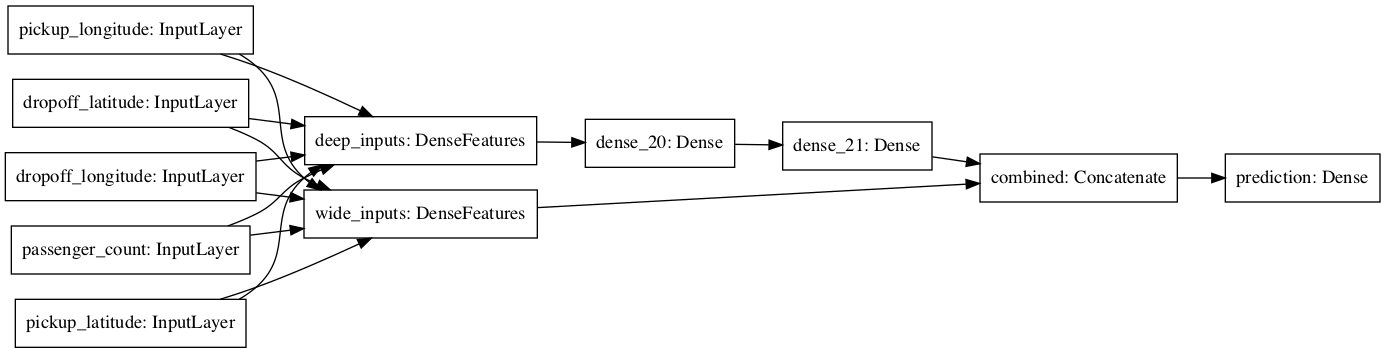

In [123]:
HIDDEN_UNITS = [10, 10]
model = build_model(dnn_hidden_units=HIDDEN_UNITS)

tf.keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

In [124]:
BATCH_SIZE = 5
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 200  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='/Users/jk/git/Study/Data/dataset/taxi-train.csv',
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN)

evalds = create_dataset(
    pattern='/Users/jk/git/Study/Data/dataset/taxi-valid.csv',
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

print(trainds.as_numpy_iterator().__next__())

(OrderedDict([('pickup_longitude', array([-74.00761 , -74.00879 , -73.95466 , -73.980354, -73.98372 ],
      dtype=float32)), ('pickup_latitude', array([40.74087 , 40.704456, 40.769615, 40.742725, 40.73855 ],
      dtype=float32)), ('dropoff_longitude', array([-73.98624, -73.95417, -73.94855, -74.00083, -74.00286],
      dtype=float32)), ('dropoff_latitude', array([40.74758 , 40.77844 , 40.77478 , 40.71001 , 40.749577],
      dtype=float32)), ('passenger_count', array([5., 2., 1., 1., 6.], dtype=float32))]), array([ 8.5, 23. ,  3.5, 12. ,  9.5], dtype=float32))


In [125]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)
50 * 1000

OUTDIR = "./taxi_trained" 
shutil.rmtree(path=OUTDIR, ignore_errors=True) # start fresh each time

history = model.fit(x=trainds,
                    steps_per_epoch=1,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    verbose=1,
                    callbacks=[TensorBoard(OUTDIR)])

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 126.5290 - rmse: 11.2485 - mse: 126.5290 - val_loss: 230.1508 - val_rmse: 14.0908 - val_mse: 230.1508
Epoch 2/200
1/1 [==============================] - 0s 191ms/step - loss: 119.4135 - rmse: 10.9276 - mse: 119.4135 - val_loss: 274.2301 - val_rmse: 14.8698 - val_mse: 274.2301
Epoch 3/200
1/1 [==============================] - 0s 112ms/step - loss: 69.1351 - rmse: 8.3148 - mse: 69.1351 - val_loss: 119.2423 - val_rmse: 10.7805 - val_mse: 119.2423
Epoch 4/200
1/1 [==============================] - 0s 114ms/step - loss: 1273.7330 - rmse: 35.6894 - mse: 1273.7330 - val_loss: 263.2978 - val_rmse: 14.3307 - val_mse: 263.2978
Epoch 5/200
1/1 [==============================] - 0s 113ms/step - loss: 300.3600 - rmse: 17.3309 - mse: 300.3600 - val_loss: 155.4675 - val_rmse: 11.2293 - val_mse: 155.4675
Epoch 6/200
1/1 [==============================] - 0s 109ms/step - loss: 2846.3059 - rmse: 53.3508 - mse: 2846.3059 - val_loss: 3

1/1 [==============================] - 0s 112ms/step - loss: 101.3877 - rmse: 10.0691 - mse: 101.3877 - val_loss: 83.8910 - val_rmse: 8.0850 - val_mse: 83.8910
Epoch 49/200
1/1 [==============================] - 0s 115ms/step - loss: 16.4118 - rmse: 4.0511 - mse: 16.4118 - val_loss: 182.5687 - val_rmse: 10.7613 - val_mse: 182.5687
Epoch 50/200
1/1 [==============================] - 0s 111ms/step - loss: 197.1815 - rmse: 14.0421 - mse: 197.1815 - val_loss: 163.7955 - val_rmse: 10.1767 - val_mse: 163.7955
Epoch 51/200
1/1 [==============================] - 0s 108ms/step - loss: 17.2913 - rmse: 4.1583 - mse: 17.2913 - val_loss: 129.5064 - val_rmse: 8.5039 - val_mse: 129.5064
Epoch 52/200
1/1 [==============================] - 0s 113ms/step - loss: 69.7427 - rmse: 8.3512 - mse: 69.7427 - val_loss: 49.4357 - val_rmse: 6.3008 - val_mse: 49.4357
Epoch 53/200
1/1 [==============================] - 0s 112ms/step - loss: 42.3368 - rmse: 6.5067 - mse: 42.3368 - val_loss: 131.0353 - val_rmse: 7.51

Epoch 96/200
1/1 [==============================] - 0s 112ms/step - loss: 17.4566 - rmse: 4.1781 - mse: 17.4566 - val_loss: 80.0497 - val_rmse: 7.7129 - val_mse: 80.0497
Epoch 97/200
1/1 [==============================] - 0s 112ms/step - loss: 20.9235 - rmse: 4.5742 - mse: 20.9235 - val_loss: 51.0300 - val_rmse: 6.5093 - val_mse: 51.0300
Epoch 98/200
1/1 [==============================] - 0s 113ms/step - loss: 22.1684 - rmse: 4.7083 - mse: 22.1684 - val_loss: 178.5335 - val_rmse: 10.1126 - val_mse: 178.5335
Epoch 99/200
1/1 [==============================] - 0s 113ms/step - loss: 87.4682 - rmse: 9.3524 - mse: 87.4682 - val_loss: 262.7659 - val_rmse: 12.0605 - val_mse: 262.7659
Epoch 100/200
1/1 [==============================] - 0s 112ms/step - loss: 1566.4443 - rmse: 39.5783 - mse: 1566.4443 - val_loss: 70.5534 - val_rmse: 7.4654 - val_mse: 70.5534
Epoch 101/200
1/1 [==============================] - 0s 112ms/step - loss: 43.2409 - rmse: 6.5758 - mse: 43.2409 - val_loss: 119.9996 - va

1/1 [==============================] - 0s 120ms/step - loss: 600.7335 - rmse: 24.5099 - mse: 600.7335 - val_loss: 60.5552 - val_rmse: 6.3655 - val_mse: 60.5552
Epoch 144/200
1/1 [==============================] - 0s 119ms/step - loss: 16.4502 - rmse: 4.0559 - mse: 16.4502 - val_loss: 129.2929 - val_rmse: 9.4706 - val_mse: 129.2929
Epoch 145/200
1/1 [==============================] - 0s 122ms/step - loss: 9.1167 - rmse: 3.0194 - mse: 9.1167 - val_loss: 72.3642 - val_rmse: 7.5129 - val_mse: 72.3642
Epoch 146/200
1/1 [==============================] - 0s 122ms/step - loss: 35.3267 - rmse: 5.9436 - mse: 35.3267 - val_loss: 56.6699 - val_rmse: 6.7337 - val_mse: 56.6699
Epoch 147/200
1/1 [==============================] - 0s 116ms/step - loss: 10.4444 - rmse: 3.2318 - mse: 10.4444 - val_loss: 23.5950 - val_rmse: 4.6815 - val_mse: 23.5950
Epoch 148/200
1/1 [==============================] - 0s 115ms/step - loss: 18.7423 - rmse: 4.3292 - mse: 18.7423 - val_loss: 191.4654 - val_rmse: 12.1565 - 

Epoch 191/200
1/1 [==============================] - 0s 113ms/step - loss: 73.0054 - rmse: 8.5443 - mse: 73.0054 - val_loss: 74.3017 - val_rmse: 6.4606 - val_mse: 74.3017
Epoch 192/200
1/1 [==============================] - 0s 111ms/step - loss: 233.7059 - rmse: 15.2874 - mse: 233.7059 - val_loss: 46.4607 - val_rmse: 6.0682 - val_mse: 46.4607
Epoch 193/200
1/1 [==============================] - 0s 113ms/step - loss: 18.9448 - rmse: 4.3526 - mse: 18.9448 - val_loss: 137.9361 - val_rmse: 10.0519 - val_mse: 137.9361
Epoch 194/200
1/1 [==============================] - 0s 113ms/step - loss: 21.6762 - rmse: 4.6558 - mse: 21.6762 - val_loss: 127.6944 - val_rmse: 9.6183 - val_mse: 127.6944
Epoch 195/200
1/1 [==============================] - 0s 120ms/step - loss: 28.3655 - rmse: 5.3259 - mse: 28.3655 - val_loss: 27.0976 - val_rmse: 5.0157 - val_mse: 27.0976
Epoch 196/200
1/1 [==============================] - 0s 117ms/step - loss: 19.5727 - rmse: 4.4241 - mse: 19.5727 - val_loss: 150.5557 - v

<AxesSubplot:>

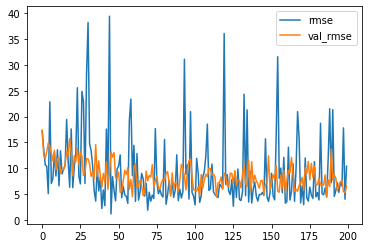

In [117]:
RMSE_COLS = ['rmse', 'val_rmse']

pd.DataFrame(history.history)[RMSE_COLS].plot()

In [17]:
%load_ext tensorboard

In [18]:
%tensorboard --logdir ./taxi_trained